In [28]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import xarray as xr

import torch
import torch.nn as nn

In [29]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True) 
        
        self.fc = nn.Linear(hidden_size, 50*24)

    def forward(self, x):
        batch_size = x.size(0) # Get the batch size
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # Initial hidden state
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :]) # Get the last output of the LSTM
        out = out.view(-1, 50, 24) # Reshape to (batch_size, mlat, mlt)
        return out
    
    def reset_states(self):
        # Reset the internal states of the LSTM layer
        self.lstm.reset_parameters()

# Instantiate the model with lookback size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model(model_path):

    lookback = 6
    model = LSTM(lookback, 64, 2)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)

    return model

NH_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/AMP_LSTM/best_lstm_model_nh_id8.pt")
SH_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/AMP_LSTM/best_lstm_model_sh_id8.pt")

In [30]:
print('model state dict:')
for param_tensor in SH_model.state_dict():
    print(param_tensor, "\t", SH_model.state_dict()[param_tensor].size())


model state dict:
lstm.weight_ih_l0 	 torch.Size([256, 6])
lstm.weight_hh_l0 	 torch.Size([256, 64])
lstm.bias_ih_l0 	 torch.Size([256])
lstm.bias_hh_l0 	 torch.Size([256])
lstm.weight_ih_l1 	 torch.Size([256, 64])
lstm.weight_hh_l1 	 torch.Size([256, 64])
lstm.bias_ih_l1 	 torch.Size([256])
lstm.bias_hh_l1 	 torch.Size([256])
fc.weight 	 torch.Size([1200, 64])
fc.bias 	 torch.Size([1200])


In [31]:
#import 2004 to 2006 data
df_open = pd.read_csv('/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro2_5min_2004_2007.csv')
#df = df.groupby(['Timestamp_1hr_omni']).mean().reset_index()
#rename Timestamp 1hr omni to dt
df = df_open.rename(columns={'Timestamp_1min_omni': 'dt'})
df['dt'] = pd.to_datetime(df['dt'])
df = df.set_index('dt')
df = df.resample('10min').mean(numeric_only=True)
df = df.dropna()
df['doy_sin'] = np.sin(2*np.pi*df['doy']/365)
df['doy_cos'] = np.cos(2*np.pi*df['doy']/365)


df = df[['BX_GSE', 'BY_GSE', 'BZ_GSE', 'flow_speed', 'proton_density','F10.7', 'doy_sin', 'doy_cos']]
#df.isnull().sum()
#ds = df.to_xarray()
#ds
df

,BX_GSE,BY_GSE,BZ_GSE,flow_speed,proton_density,F10.7,doy_sin,doy_cos
dt,,,,,,,,
2004-01-01 00:00:00,-2.110,2.635,8.835,528.5,6.6350,112.0,1.721336e-02,0.999852
2004-01-01 00:10:00,-3.945,6.720,1.825,523.5,7.2050,112.0,1.721336e-02,0.999852
2004-01-01 00:20:00,-5.010,5.920,-0.365,523.0,7.2500,112.0,1.721336e-02,0.999852
2004-01-01 00:30:00,-5.655,5.090,5.855,522.5,6.1400,112.0,1.721336e-02,0.999852
2004-01-01 00:40:00,-4.765,8.570,-0.345,524.0,6.7150,112.0,1.721336e-02,0.999852
...,...,...,...,...,...,...,...,...
2007-12-31 23:10:00,-1.965,3.950,-1.525,350.0,6.9100,74.0,6.432491e-16,1.000000
2007-12-31 23:20:00,-2.950,2.475,-1.545,345.5,6.8950,74.0,6.432491e-16,1.000000
2007-12-31 23:30:00,-3.665,2.950,-1.655,345.0,6.9650,74.0,6.432491e-16,1.000000


In [32]:
def clock_angle(By, Bz):
    angle = np.rad2deg(np.arctan2(By, Bz))
    np.where(angle < 0, angle + 360, angle)
    return angle

def calc_akasofu(v_sw, Bx, By, Bz):
    #https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2002JA009283
    #In SI units
    v_sw = v_sw * 1e3
    Bx = Bx * 10e-9
    By = By * 10e-9
    Bz = Bz * 10e-9
    B = np.sqrt(Bx**2 + By**2 + Bz**2)
    l_0 = 6371 * 7 * 1e3 #7 R_E
    mu_0 = np.pi * 4 * 10e-6
    #mu_0 = 1.2566370614e-6
    theta  = clock_angle(By, Bz)
    epsilon_A = (4 * np.pi / mu_0) * v_sw * B**2 * np.sin(theta / 2)**4 * l_0**2
    #epsilon_A = np.log10(epsilon_A + 1)

    return epsilon_A

#df['epislon_A'] = calc_akasofu(df['flow_speed'], df['BX_GSE'], df['BY_GSE'], df['BZ_GSE'])
#df


In [33]:
lookback = 6

def make_predictions(model, df, hemi):

    def split_to_df(df):

        df = df.reset_index()

        df_2 = df.copy()
        df_2 = df_2.drop(columns=['dt'])
        
        return df, df_2

    df_raw, df_proc = split_to_df(df)

    with open(f'/home/sachin/Documents/NIPR/Research/Data/ML/AMP_LSTM/scaler_{hemi}_id8.pkl', 'rb') as f:
        scaler = pickle.load(f)

    col_names = df_proc.columns
    norm_arr = scaler.transform(df_proc)
    df_proc = pd.DataFrame(norm_arr, columns=col_names)
    df_proc = df_proc.to_numpy()

    def create_sequences(arr):
        X = []
        for i in range(len(arr) - lookback):
            X.append(arr[i:i+lookback].T)

        X = np.array(X)

        return X

    proc_seq = create_sequences(df_proc)
    proc_seq = torch.tensor(proc_seq, dtype=torch.float32).to(device)

    predictions = []
    with torch.no_grad():
        for i in range(len(proc_seq)):
            pred = model(proc_seq[i].unsqueeze(0))
            predictions.append(pred)

    predictions = torch.cat(predictions)
    predictions = predictions.to('cpu').numpy()

    return predictions, df_raw

NH_predictions, df_raw = make_predictions(NH_model, df, 'nh')
SH_predictions, df_raw = make_predictions(SH_model, df, 'sh')

/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [34]:
ds = xr.Dataset({'jPar_NH': (['dt', 'mlat', 'mlt'], NH_predictions),
                 'jPar_SH': (['dt', 'mlat', 'mlt'], SH_predictions),
                'F107': (['dt'], df_raw['F10.7'].values[lookback:]),
                 },
                coords = {'dt': df_raw['dt'].values[lookback:], 'mlat': np.arange(40, 90, 1), 'mlt': np.arange(0, 24, 1)})
ds = ds.resample(dt='1M').mean()
ds['jPar_diff'] = ds['jPar_NH'] - ds['jPar_SH']
ds


/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


<xarray.Dataset> Size: 693kB
Dimensions:    (dt: 48, mlat: 50, mlt: 24)
Coordinates:
  * mlat       (mlat) int64 400B 40 41 42 43 44 45 46 ... 83 84 85 86 87 88 89
  * mlt        (mlt) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * dt         (dt) datetime64[ns] 384B 2004-01-31 2004-02-29 ... 2007-12-31
Data variables:
    jPar_NH    (dt, mlat, mlt) float32 230kB -0.01583 -0.01384 ... -0.01392
    jPar_SH    (dt, mlat, mlt) float32 230kB -0.007106 -0.0001765 ... 0.007462
    F107       (dt) float64 384B 110.0 103.1 110.5 101.2 ... 66.61 67.69 75.84
    jPar_diff  (dt, mlat, mlt) float32 230kB -0.008723 -0.01367 ... -0.02138

<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_6555/1902643458.py:28: SyntaxWarning: invalid escape sequence '\p'
  plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.5, pad = 0.18,


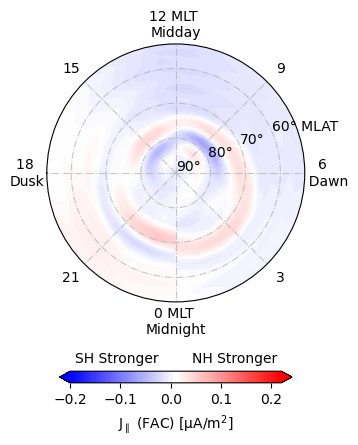

In [38]:
fac = ds['jPar_diff'].values.mean(axis=0)

fac = fac.reshape(24, 50).T # reshape and transpose
fac = np.flipud(fac) # flip the array upside down
theta = np.linspace(0, 360, 24) - 90 # rotate by 90 degrees
theta = np.radians(theta) # convert to radians
r = 90 - np.linspace(40, 90, 50) #convert to colat

#cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["blue","blue", "white", "white","red","red"])
cmap = 'bwr'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 5))

c = ax.contourf(theta, r, fac, cmap=cmap, levels=np.linspace(-.2, .22, 100), extend='both')
ax.set_ylim([0,37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-.', alpha=0.7)
#ax.set_title(f"{dt}", pad=10, fontsize=11.5)

#add text above colorbar
ax.text(0.73, -0.22, 'NH Stronger', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)
ax.text(0.27, -0.22, 'SH Stronger', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)

plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.5, pad = 0.18, 
             ticks=[-.2, -.1, 0, 0.1, 0.2], 
             orientation='horizontal')

<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_6555/2284350260.py:29: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('FAC (J$_\parallel$) [µA/m$^2$]')


Text(0, 0.5, 'FAC (J$_\\parallel$) [µA/m$^2$]')

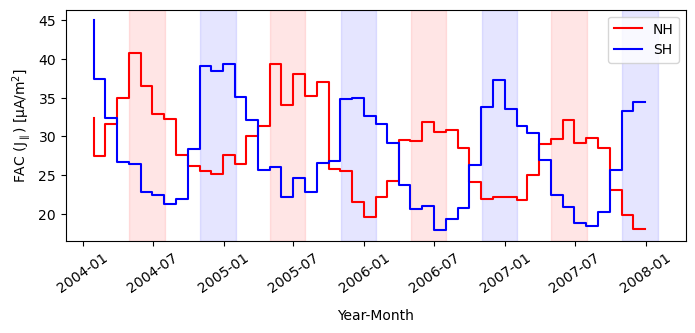

In [37]:
dt = ds['dt'].values.flatten()
jpar_NH = ds['jPar_NH'].values
jpar_NH = np.abs(jpar_NH).sum(axis=(1,2)).flatten()
jpar_SH = ds['jPar_SH'].values
jpar_SH = np.abs(jpar_SH).sum(axis=(1,2)).flatten()
F107 = ds['F107'].values.flatten()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))

sns.lineplot(x=dt, y=jpar_NH, label='NH', color='red',drawstyle='steps-pre')
#sns.regplot(x=dt, y=jpar_NH, scatter=False, color='red')
sns.lineplot(x=dt, y=jpar_SH, label='SH', color='blue',drawstyle='steps-pre')


#add light blue shape between november and january for all years
nov = pd.Timestamp('11-01')
jan = pd.Timestamp('01-01')
for i in range(2004, 2008):
    ax.axvspan(pd.Timestamp(f'{i}-11-01'), pd.Timestamp(f'{i+1}-02-01'), color='blue', alpha=0.1)

#may = pd.Timestamp('05-01')
#jul = pd.Timestamp('07-01')
for i in range(2004, 2008):
    ax.axvspan(pd.Timestamp(f'{i}-05-01'), pd.Timestamp(f'{i}-08-01'), color='red', alpha=0.1)

plt.xlabel('Year-Month', labelpad=10)
#rotate x-axis labels
plt.xticks(rotation=35)
plt.ylabel('FAC (J$_\parallel$) [µA/m$^2$]')
#plt.savefig('LSTM_NH_SH_current_asymmetry_bartels.png', dpi=500, bbox_inches='tight')

<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_6555/3904764153.py:39: SyntaxWarning: invalid escape sequence '\p'
  ax2.set_ylabel('FAC (J$_\parallel$) [µA/m$^2$]')


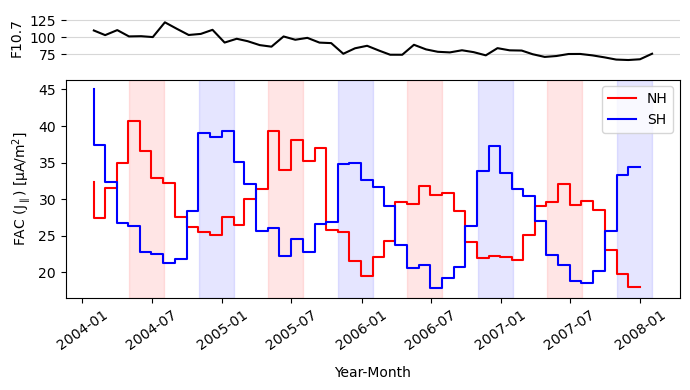

In [36]:
#get data
dt = ds['dt'].values.flatten()
jpar_NH = ds['jPar_NH'].values
jpar_NH = np.abs(jpar_NH).sum(axis=(1,2)).flatten()
jpar_SH = ds['jPar_SH'].values
jpar_SH = np.abs(jpar_SH).sum(axis=(1,2)).flatten()
F107 = ds['F107'].values.flatten()

# Create a figure with GridSpec
fig = plt.figure(figsize=(7, 4))
gs = fig.add_gridspec(2, 1, height_ratios=[0.2, 0.8])

# Create the F107 plot on top
ax1 = fig.add_subplot(gs[0, 0])
sns.lineplot(x=dt, y=F107, ax=ax1, color='k')
ax1.set_ylabel('F10.7')
ax1.set_yticks([75, 100, 125])
ax1.set_ylim([60, 140])
ax1.set_xticks([])  # Hide x-ticks on the top plot
#remove spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.grid(True, axis='y', linestyle='-', alpha=0.5)

# Create the main plot below
ax2 = fig.add_subplot(gs[1, 0])
sns.lineplot(x=dt, y=jpar_NH, ax=ax2, label='NH', color='red', drawstyle='steps-pre')
sns.lineplot(x=dt, y=jpar_SH, ax=ax2, label='SH', color='blue', drawstyle='steps-pre')

# Highlight regions
for i in range(2004, 2008):
    ax2.axvspan(pd.Timestamp(f'{i}-11-01'), pd.Timestamp(f'{i+1}-02-01'), color='blue', alpha=0.1)
    ax2.axvspan(pd.Timestamp(f'{i}-05-01'), pd.Timestamp(f'{i}-08-01'), color='red', alpha=0.1)

# Labels and formatting
ax2.set_xlabel('Year-Month', labelpad=10)
ax2.set_ylabel('FAC (J$_\parallel$) [µA/m$^2$]')
plt.xticks(rotation=35)

plt.tight_layout()
#plt.savefig('LSTM_NH_SH_current_asymmetry_bartels.png', dpi=500, bbox_inches='tight')


<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_29188/1295898623.py:28: SyntaxWarning: invalid escape sequence '\p'
  plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.5, pad = 0.18,


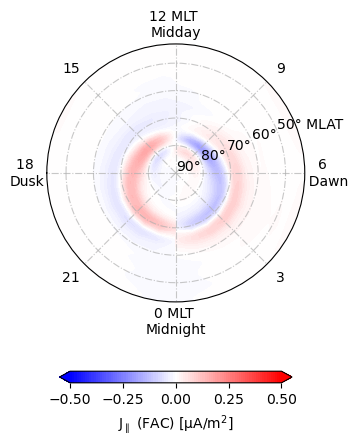

In [11]:
fac = ds['jPar_NH'].values.mean(axis=0)

fac = fac.reshape(24, 50).T # reshape and transpose
fac = np.flipud(fac) # flip the array upside down
theta = np.linspace(0, 360, 24) - 90 # rotate by 90 degrees
theta = np.radians(theta) # convert to radians
r = 90 - np.linspace(40, 89, 50) #convert to colat

#cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["blue","blue", "white", "white","red","red"])
cmap = 'bwr'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 5))

c = ax.contourf(theta, r, fac, cmap=cmap, levels=np.linspace(-.5, .5, 100), extend='both')
ax.set_ylim([0,47])
ax.set_yticks([0, 10, 20, 30, 40])
ax.set_yticklabels(["90°", "80°", "70°", "60°", "50° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-.', alpha=0.7)
#ax.set_title(f"{dt}", pad=10, fontsize=11.5)

#add text above colorbar
#ax.text(0.73, -0.22, 'NH Stronger', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)
#ax.text(0.27, -0.22, 'SH Stronger', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)

plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.5, pad = 0.18, 
             ticks=[-.5, -.25, 0, 0.25, 0.5], 
             orientation='horizontal')

plt.savefig('LSTM_NH_current_asymmetry_radar.png', dpi=500, bbox_inches='tight')
